In [5]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearRegression,
    LogisticRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [53]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 25
SIZE = 50
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 3050 Laptop GPU


In [54]:
X = torch.randn(SIZE, 2, dtype=DTYPE, device='cpu')
y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + .3 * torch.randn(SIZE, dtype=DTYPE, device='cpu')

In [55]:
# Targets for Logistic Regression
probs = torch.sigmoid(y)
print(f"Probabilities:\n{probs}")

Probabilities:
tensor([0.0147, 0.9999, 0.9953, 0.2809, 0.7384, 1.0000, 0.9972, 0.9999, 0.8415,
        0.7846, 0.9715, 1.0000, 0.9642, 0.9994, 0.9996, 0.9946, 0.9999, 0.8069,
        0.9887, 0.9968, 0.9982, 0.9989, 0.9569, 0.9998, 0.9999, 0.9575, 0.9998,
        0.9999, 0.9859, 0.9563, 0.9568, 0.9990, 0.9927, 0.9999, 0.9906, 0.9269,
        1.0000, 0.9863, 0.0125, 0.8934, 0.9409, 0.9980, 1.0000, 0.9913, 0.9812,
        0.9887, 0.9999, 0.9999, 0.9883, 0.8610])


In [56]:
y = (probs > .98).float()
print(f"Targets for logistic regression task:\n{y}")

Targets for logistic regression task:
tensor([0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.])


In [57]:
# Frequency of labels
print(f"# of Targets (0 and 1):" , "-> 0: {}".format(y[y == 0].numel()), "-> 1: {}".format(y[y == 1].numel()), sep="\n")

# of Targets (0 and 1):
-> 0: 17
-> 1: 33


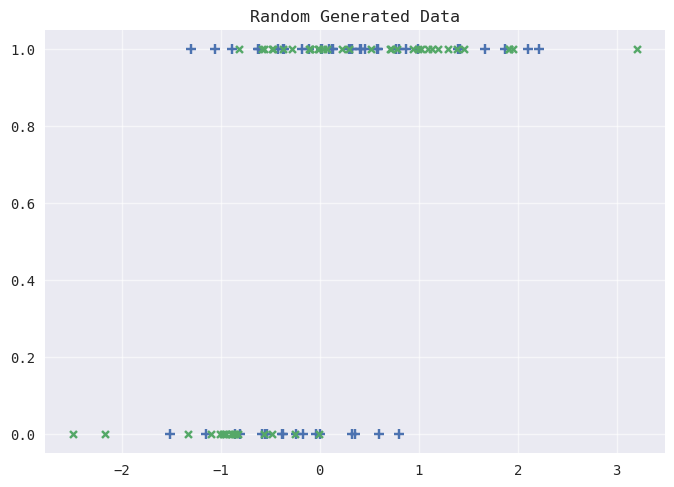

In [58]:
plt.scatter(X[:, 0].numpy(), y.numpy(), marker='+', s=50);
plt.scatter(X[:, 1].numpy(), y.numpy(), marker='x', s=25);
# plt.plot(
#     torch.sigmoid(torch.linspace(y.min(), y.max(), SIZE))
# )
plt.grid(True, alpha = .6);
plt.title("Random Generated Data");
plt.show()

In [47]:
X, X.shape

(tensor([[ 0.8641, -0.0161],
         [-0.4310,  0.6421],
         [-1.9359, -0.0114],
         [ 1.0178, -1.1055],
         [-1.0009, -0.7390],
         [-1.7565,  0.1776],
         [ 0.4568,  0.7857],
         [ 1.2828,  1.9168],
         [ 0.2592, -0.7775],
         [ 2.6352, -0.8467],
         [ 1.3651,  0.2715],
         [ 1.4192, -0.1184],
         [ 1.4488,  0.0869],
         [-0.7148,  1.2985],
         [-0.0688,  0.0189],
         [-1.1000,  1.0580],
         [ 1.5683, -0.5060],
         [ 0.7554, -0.7548],
         [ 1.3178, -1.4506],
         [-0.0771,  1.1842],
         [ 0.2710, -0.3486],
         [-0.1622, -0.3565],
         [-0.4923,  0.1804],
         [ 1.3663, -1.6679],
         [-0.9722, -0.8237],
         [-0.0820, -0.4293],
         [ 0.3233, -2.2621],
         [ 0.2095, -1.0119],
         [ 0.5830, -2.0466],
         [ 0.0664,  0.3360],
         [ 0.0986, -0.8650],
         [-0.2876,  1.1866],
         [-0.5541,  0.2906],
         [-0.8841,  0.9315],
         [-1.2

In [10]:
y, y.shape

(tensor([ 6.8105e+00,  6.2803e+00,  1.1704e+00,  3.7082e+00,  1.0107e+00,
          1.4840e+00,  8.5679e+00,  1.3233e+01,  3.7743e+00,  7.2281e+00,
          8.6398e+00,  7.5484e+00,  8.1489e+00,  7.4842e+00,  4.6474e+00,
          5.8384e+00,  6.7993e+00,  3.9808e+00,  3.0137e+00,  8.7677e+00,
          4.2248e+00,  4.0419e+00,  4.7440e+00,  3.1473e+00,  2.3510e-01,
          3.7905e+00, -1.1968e+00,  2.6225e+00, -7.8762e-03,  6.4412e+00,
          2.7023e+00,  7.7602e+00,  4.9476e+00,  6.4130e+00,  1.1059e+00,
          4.9735e-01,  3.2123e+00,  2.6993e+00,  6.2049e-01,  4.6862e+00,
          5.0694e+00,  5.9407e+00, -8.0516e-01,  1.0425e+01,  4.8566e+00,
          3.8118e+00,  2.4107e+00, -1.7932e+00,  1.0969e+01,  3.5814e+00,
          7.6697e+00,  5.4936e-01,  8.7569e-01,  5.8638e+00,  5.7093e+00,
         -4.8259e-01,  3.4402e+00,  7.3356e+00,  3.1350e+00, -2.0488e-01,
          5.2688e+00,  5.0848e+00,  2.7712e+00,  6.5529e+00,  9.5142e+00,
          2.8383e+00,  6.0230e+00,  1.

In [11]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[ 0.8641, -0.0161],
         [-0.4310,  0.6421],
         [-1.9359, -0.0114],
         [ 1.0178, -1.1055],
         [-1.0009, -0.7390],
         [-1.7565,  0.1776],
         [ 0.4568,  0.7857],
         [ 1.2828,  1.9168],
         [ 0.2592, -0.7775],
         [ 2.6352, -0.8467],
         [ 1.3651,  0.2715],
         [ 1.4192, -0.1184],
         [ 1.4488,  0.0869],
         [-0.7148,  1.2985],
         [-0.0688,  0.0189],
         [-1.1000,  1.0580],
         [ 1.5683, -0.5060],
         [ 0.7554, -0.7548],
         [ 1.3178, -1.4506],
         [-0.0771,  1.1842],
         [ 0.2710, -0.3486],
         [-0.1622, -0.3565],
         [-0.4923,  0.1804],
         [ 1.3663, -1.6679],
         [-0.9722, -0.8237],
         [-0.0820, -0.4293],
         [ 0.3233, -2.2621],
         [ 0.2095, -1.0119],
         [ 0.5830, -2.0466],
         [ 0.0664,  0.3360],
         [ 0.0986, -0.8650],
         [-0.2876,  1.1866],
         [-0.5541,  0.2906],
         [-0.8841,  0.9315],
         [-1.2

In [14]:
# Test One-hot Endcoding
torch.eye(4, dtype=DTYPE)[y]

IndexError: tensors used as indices must be long, int, byte or bool tensors

In [ ]:
Model = LogisticRegression(in_dims=2).to(DEVICE)

In [28]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.L1Loss(reduction='mean'),
    device=DEVICE
)

In [30]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([ 0.2684, -0.3284], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.5805], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.2854, -0.3391], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.4805], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.3306, -0.3393], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.4055], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.3008, -0.3507], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.3118], device='cuda:0')
	Epoch 1 | Weights: tensor([ 0.3389, -0.3159], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.2180], device='cuda:0')
Epoch 1/25 | Loss: 5.2355
	| Validation Loss: 4.9648

	Epoch 2 | Weights: tensor([ 0.3495, -0.3210], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.1243], device='cuda:0')
	Epoch 2 | Weights: tensor([ 0.3651, -0.3064], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.0305], device='cuda:0')
	Epoch 2 | Weights: tensor([ 0.3773, -0.2790], device='cuda:0')
	Epoch 2 | Bias: tensor([0.0570], device='cuda:0')
	Epoch 2 | Weights:

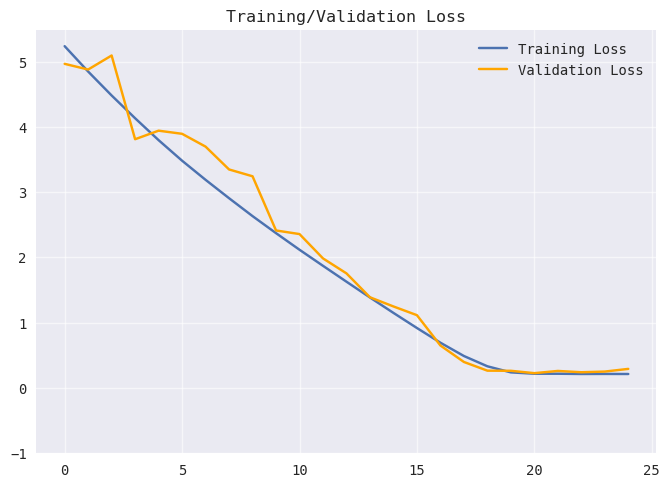

In [31]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-1)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [32]:
# y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')
print(
    f"Trained Weights: {Model.w.data}",
    f"Trained Bias: {Model.b.data}",
    sep="\n"
)

Trained Weights: tensor([2.0244, 3.0298], device='cuda:0')
Trained Bias: tensor([5.0007], device='cuda:0')


In [33]:
# Analytical Solution
# First, bias must be added to the design matrix
X = torch.tensor(np.concatenate([X, np.ones((SIZE, 1))], axis=1), dtype=DTYPE, device='cpu')

w = torch.linalg.inv(X.T @ X) @ X.T @ y
print(f"Analytical Solution for Weights: {w}")

Analytical Solution for Weights: tensor([2.0322, 3.0169, 4.9932])


In [34]:
T = np.linspace(X.min(), X.max(), SIZE, dtype=np.float32).reshape(SIZE, 1)
T = torch.tensor(np.concatenate([T, T], axis=1), device=DEVICE)

# Inference
with torch.no_grad():
    yT = Model(T)

print(f"\nGenerated T:\n{T}")
print(f"\nPredictions:\n{yT}")


Generated T:
tensor([[-2.8807, -2.8807],
        [-2.8535, -2.8535],
        [-2.8263, -2.8263],
        [-2.7990, -2.7990],
        [-2.7718, -2.7718],
        [-2.7445, -2.7445],
        [-2.7173, -2.7173],
        [-2.6900, -2.6900],
        [-2.6628, -2.6628],
        [-2.6355, -2.6355],
        [-2.6083, -2.6083],
        [-2.5811, -2.5811],
        [-2.5538, -2.5538],
        [-2.5266, -2.5266],
        [-2.4993, -2.4993],
        [-2.4721, -2.4721],
        [-2.4448, -2.4448],
        [-2.4176, -2.4176],
        [-2.3904, -2.3904],
        [-2.3631, -2.3631],
        [-2.3359, -2.3359],
        [-2.3086, -2.3086],
        [-2.2814, -2.2814],
        [-2.2541, -2.2541],
        [-2.2269, -2.2269],
        [-2.1996, -2.1996],
        [-2.1724, -2.1724],
        [-2.1452, -2.1452],
        [-2.1179, -2.1179],
        [-2.0907, -2.0907],
        [-2.0634, -2.0634],
        [-2.0362, -2.0362],
        [-2.0089, -2.0089],
        [-1.9817, -1.9817],
        [-1.9545, -1.9545],
      

In [35]:
T.shape, yT.shape

(torch.Size([200, 2]), torch.Size([200]))

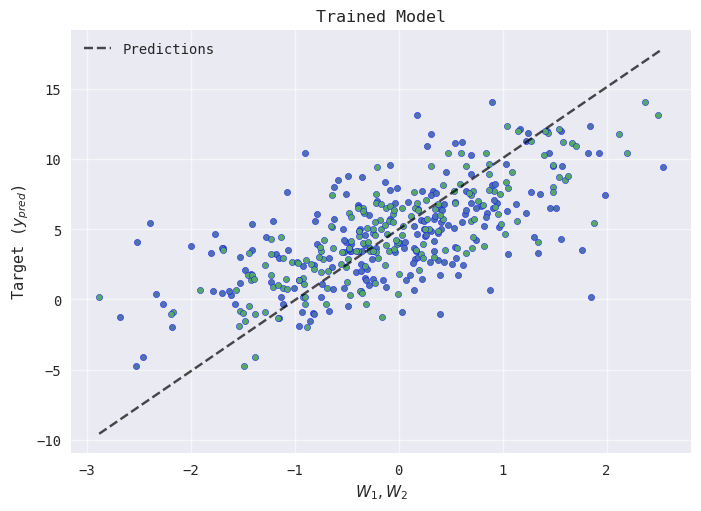

In [36]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
# Predicted Linear Model
plt.plot(T[:, 0].cpu().numpy(), yT.cpu().numpy(), color="black", alpha=.7, linestyle='--', label="Predictions");
plt.grid(True, alpha = .6);
plt.title("Trained Model");
plt.xlabel("$W_1, W_2$");
plt.ylabel("Target ($y_{pred}$)");
plt.legend(loc='best');
plt.show()